In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplhep as hep
import numpy as np
plt.style.use(hep.style.CMS)

from plotting import *
from data import *

In [2]:
def load_limit(file):
    with open(file, 'r') as f:
        limits = [float(x[:-1].split(' ')[-1]) for x in f]
        if limits == []: return None, [None, None], [None, None]
        median = limits[2]
        cl_95 = [limits[0], limits[4]]
        cl_68 = [limits[1], limits[3]]
        return median, cl_68, cl_95
    
def load_limits(directory, year, channel, spinpostfix = "", observed=False):
    medians = []
    cl_68_ups = []
    cl_68_downs = []
    cl_95_ups = []
    cl_95_downs = []

    for masspoint in masspoints:
        if observed: filename = directory + "/AsymptoticLimits_" + year + "_" + str(masspoint) + "_" + channel + spinpostfix + "_observed.txt"
        else: filename = directory + "/AsymptoticLimits_" + year + "_" + str(masspoint) + "_" + channel + spinpostfix + ".txt"
        median, cl_68, cl_95 = load_limit(filename)

        medians.append(median)
        cl_68_downs.append(cl_68[0])
        cl_68_ups.append(cl_68[1])
        cl_95_downs.append(cl_95[0])
        cl_95_ups.append(cl_95[1])
        
    return np.asarray([medians, cl_68_ups, cl_68_downs, cl_95_ups, cl_95_downs], dtype=float)

def scalelimit(limits, signalscalings):
    
    new_limits = []
    for limit in limits:
        new_limits.append( np.multiply(limit, signalscalings) )
    return new_limits

In [3]:
masspoints = [700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2250, 2500, 2750, 3000]

In [4]:
# expected limits
spin = ""
outputdir = "outputs"
dosplit = False

limits = load_limits(outputdir, "", "total", spin)
limits_observed = load_limits(outputdir, "", "total", spin, observed = True)

if dosplit:
    limits_mu = load_limits(outputdir, "", "mu", spin)
    limits_mu_observed = load_limits(outputdir, "", "mu", spin, observed = True)
    limits_ele = load_limits(outputdir, "", "ele", spin)
    limits_ele_observed = load_limits(outputdir, "", "ele", spin, observed = True)

In [5]:
# scaling (the same way as in the "create cards!!!")
signalscalings = [1./100.] * 18 # scaling all down by factor 100, but ONLY DO THIS FOR SR!!!

limits = scalelimit(limits, signalscalings)
limits_observed = scalelimit(limits_observed, signalscalings)


if dosplit:
    limits_mu = scalelimit(limits_mu, signalscalings)
    limits_ele = scalelimit(limits_ele, signalscalings)
    limits_mu_observed = scalelimit(limits_mu_observed, signalscalings)
    limits_ele_observed = scalelimit(limits_ele_observed, signalscalings)

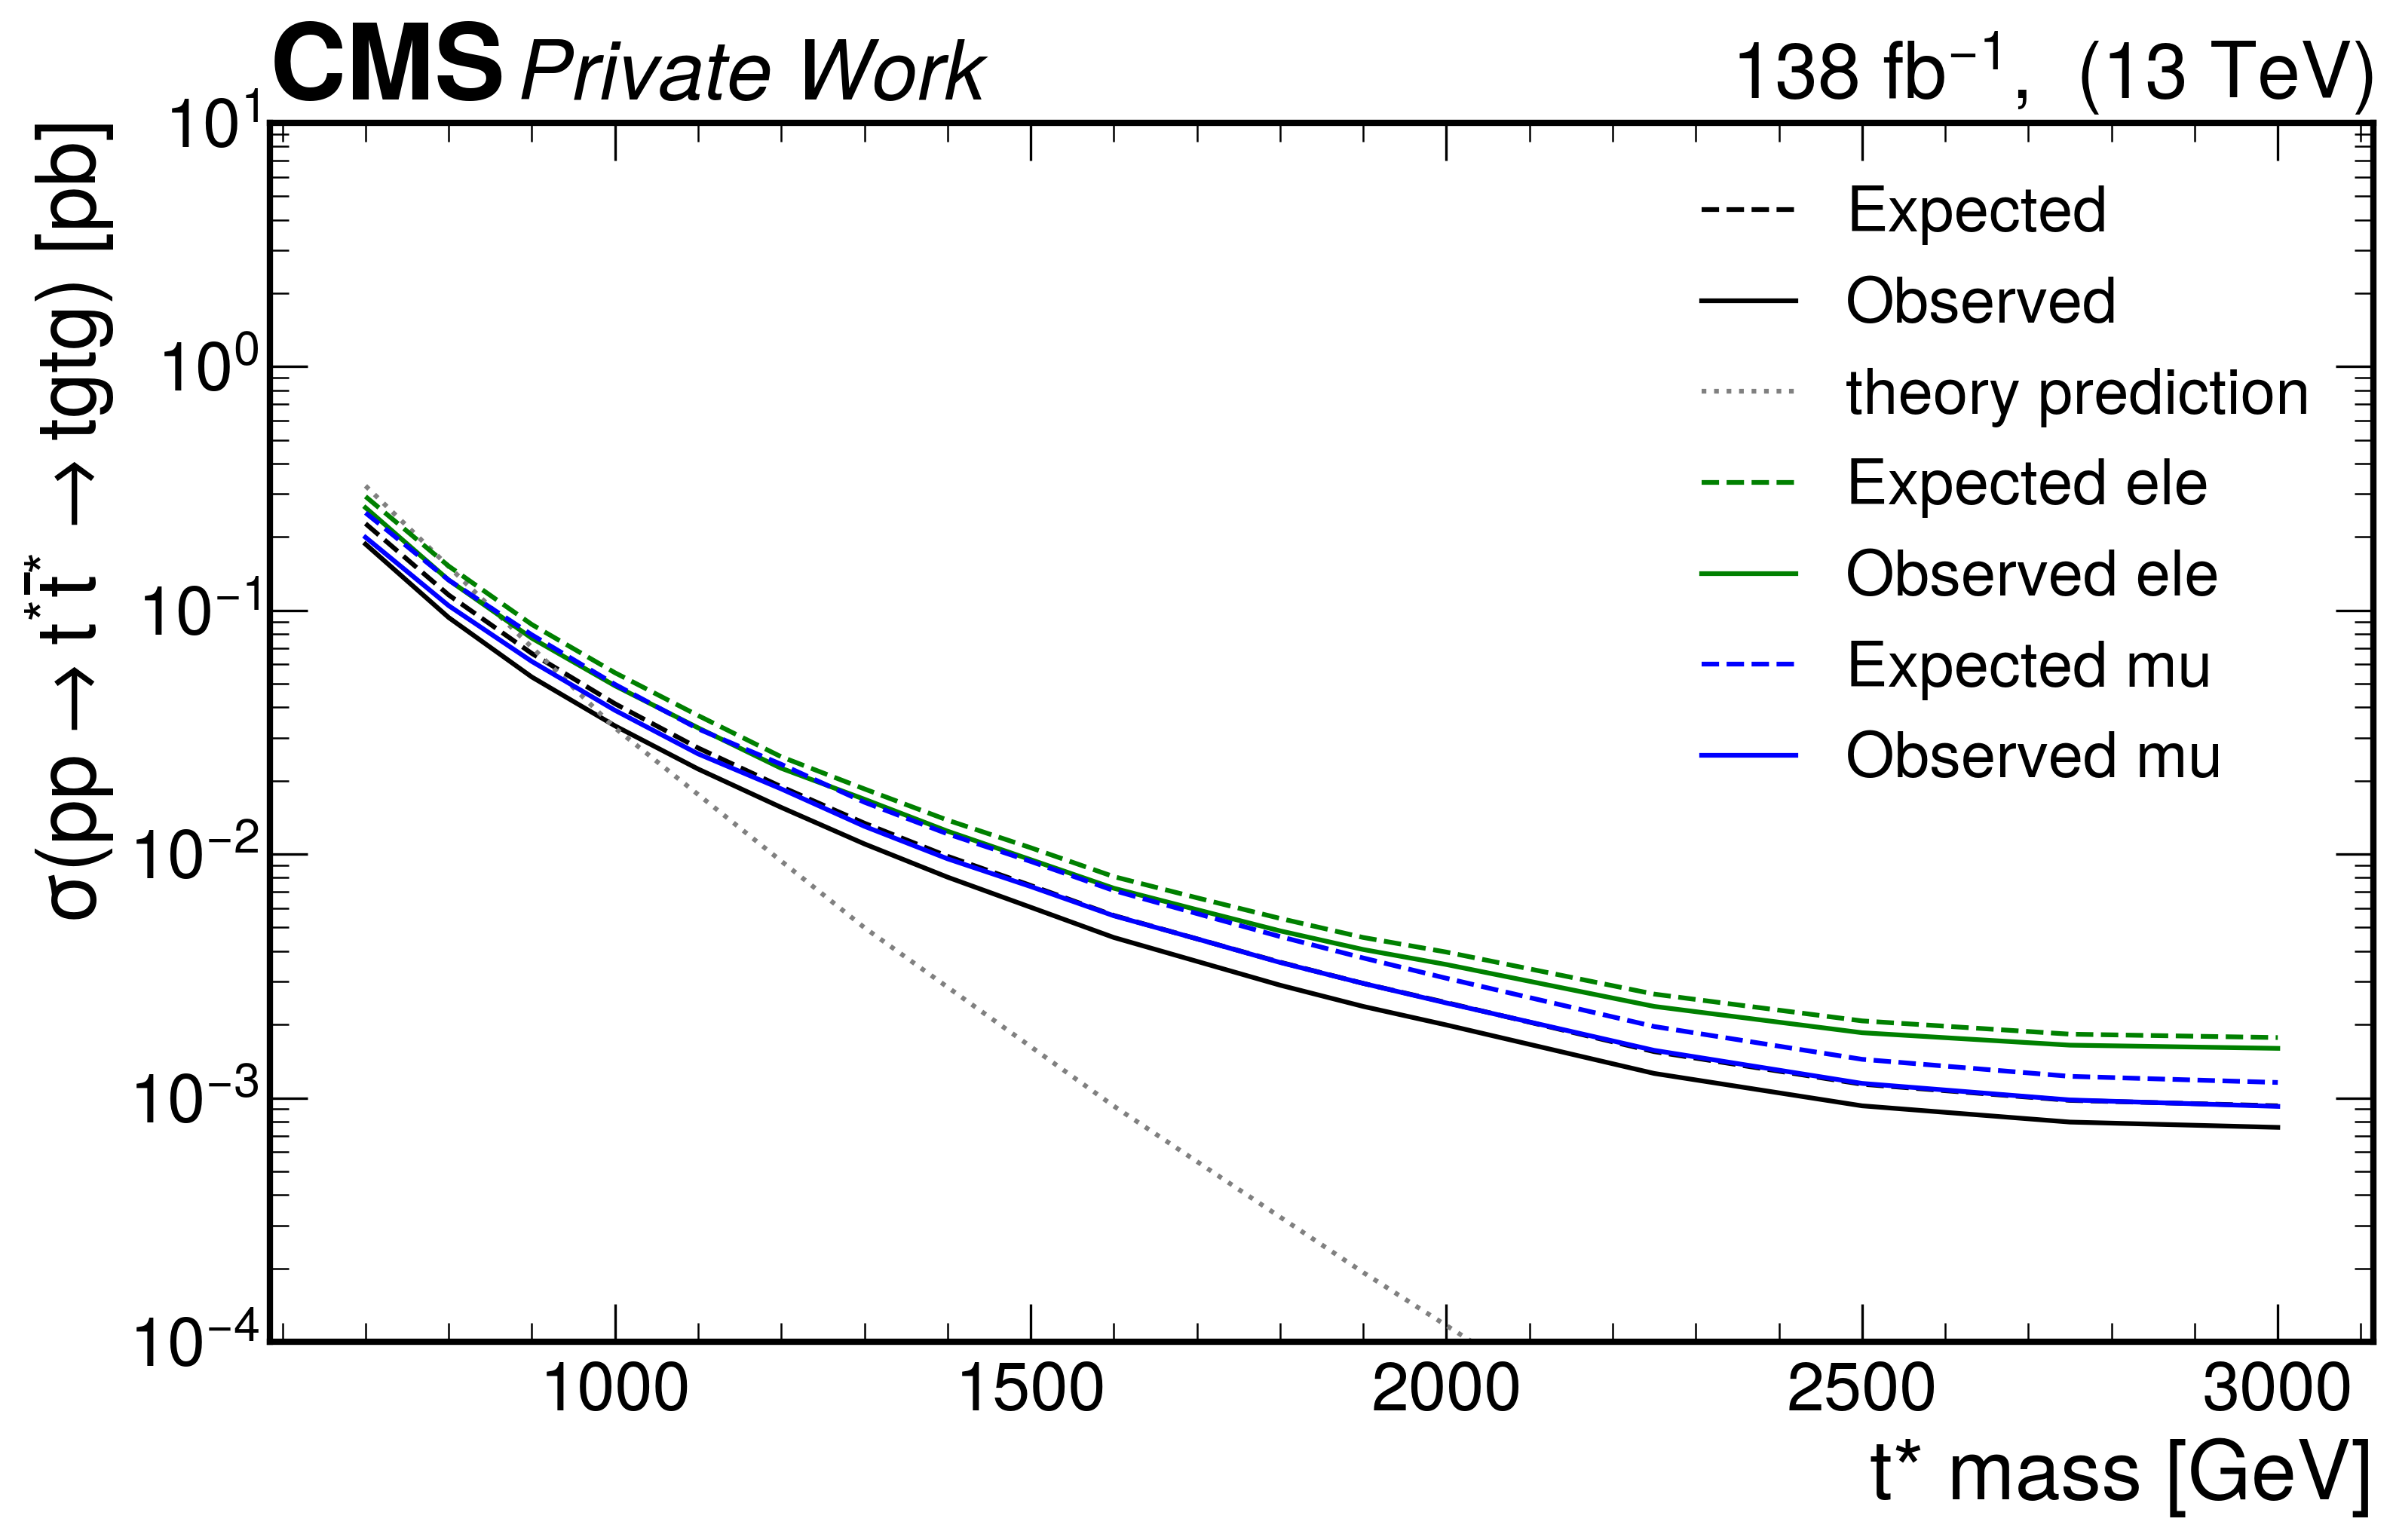

In [6]:
fig, ax = plot_skeleton("", "Private Work")

if not dosplit:
    ax.fill_between(masspoints, limits[4], limits[3], color = 'gold', label = '95% expected')
    ax.fill_between(masspoints, limits[2], limits[1], color = 'g', label = '68% expected')
ax.plot(masspoints, limits[0], 'k--', label = 'Expected')

ax.plot(masspoints, limits_observed[0], 'k-', label = 'Observed')

if (spin == "_Spin32"):
    plot_other_line(get_theory_line(spin = 1.5, source="MadGraph noBR"), linestyle = ":", color = "grey", label = r"theory prediction", ax=ax)
    plot_other_line(get_last_cms("expected"), ax=ax, color="red", linestyle = "--", label="2016 CMS expected")
    plot_other_line(get_last_cms("observed"), ax=ax, color="red", label="2016 CMS observed")
else:
    plot_other_line(get_theory_line(spin = 0.5, source="MadGraph noBR"), linestyle = ":", color = "grey", label = r"theory prediction", ax=ax)

if dosplit:
    ax.plot(masspoints, limits_ele[0], 'g--', label = 'Expected ele')
    ax.plot(masspoints, limits_ele_observed[0], 'g-', label = 'Observed ele')
    ax.plot(masspoints, limits_mu[0], 'b--', label = 'Expected mu')
    ax.plot(masspoints, limits_mu_observed[0], 'b-', label = 'Observed mu')
    
ax.set_yscale("log")

ax.set_xlabel("t* mass [GeV]")
#ax.set_ylabel(r"$\sigma(pp \rightarrow t^{*}\bar{t}^{*}) \times BR(t^{*} \rightarrow tg)^2~[pb]$")
ax.set_ylabel(r"$\sigma(pp \rightarrow t^{*}\bar{t}^{*} \rightarrow tgtg)~[pb]$")

plt.legend(prop={'size': 20})

plt.ylim(1e-4, 10)
#plt.xlim(700, 2000)


if (spin == "_Spin32"): outputname = "plots/limits_32"
else: outputname = "plots/limits_12"

if dosplit: outputname += "_csplit"

plt.savefig(outputname + ".pdf")
plt.show()

In [7]:
# print range of exclusion
def exclusion_range(this_limits):

    min_limit = 99999
    min_limit_mass = 0
    max_limit = -99999
    max_limit_mass = 0

    for masspoint, limit in zip(masspoints, this_limits[0]):

        if limit > max_limit:
            max_limit = limit
            max_limit_mass = masspoint
        if limit < min_limit:
            min_limit = limit
            min_limit_mass = masspoint

    print(f"Found lowest limit at {min_limit_mass} GeV with {min_limit} pb.")
    print(f"Found highest limit at {max_limit_mass} GeV with {max_limit} pb.")
    
from scipy.interpolate import interp1d

def get_crossing(masspoints, limits, theory_line):
    
    x2 = np.asarray(list(theory_line.keys()))
    y2 = np.asarray(list(theory_line.values()))[:,0]
    
    # logging to make linear interpolation better
    limits = np.log(limits)
    y2 = np.log(y2)
    
    f1 = interp1d(masspoints, limits, kind='linear')
    f2 = interp1d(x2, y2, kind='linear')

    x_test = np.arange(700, 2500, 1)
    
    y_1 = f1(x_test)
    y_2 = f2(x_test)
    
    diff = y_1 - y_2
    
    signs = np.sign(diff)

    # Compute the difference between consecutive signs
    sign_diff = np.diff(signs)

    # Identify indices where the difference is non-zero
    sign_change_indices = np.where(sign_diff != 0)[0]

    print("Crossing is at {} GeV".format(x_test[sign_change_indices]))

In [8]:
print("Expected:")
exclusion_range(limits)
print("Observed:")
exclusion_range(limits_observed)

Expected:
Found lowest limit at 3000 GeV with 0.000928 pb.
Found highest limit at 700 GeV with 0.226875 pb.
Observed:
Found lowest limit at 3000 GeV with 0.0007570000000000001 pb.
Found highest limit at 700 GeV with 0.186875 pb.


In [9]:
# pring crossing value
if (spin == "_Spin32"):
    
    print("Expected:")
    get_crossing(masspoints, limits[0], get_theory_line(spin = 1.5, source="MadGraph noBR"))
    
    print("Observed:")
    get_crossing(masspoints, limits_observed[0], get_theory_line(spin = 1.5, source="MadGraph noBR"))
else:
    print("Expected:")
    get_crossing(masspoints, limits[0], get_theory_line(spin = 0.5, source="MadGraph noBR"))
    
    print("Observed:")
    get_crossing(masspoints, limits_observed[0], get_theory_line(spin = 0.5, source="MadGraph noBR"))

Expected:
Crossing is at [920] GeV
Observed:
Crossing is at [993] GeV
